# RL and Advanced DL: Домашнее задание 3
Третье домашнее задание посвящено порождающим моделям, а точнее — порождающим состязательным сетям. Это самое маленькое и самое техническое задание в курсе, но что уж поделать. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

## Часть первая: перенос стиля при помощи pix2pix

В этом задании мы будем реализовывать перенос стиля на спаренных данных (paired data). Из стандартных датасетов я выбрал самый маленький -- давайте реализуем перенос стиля из масок сегментации в “настоящие фотографии” для конкретного случая фасадов домов:


In [1]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz

!tar -xf facades.tar.gz

--2021-12-28 23:20:44--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz.8’

facades.tar.gz.8    100%[===================>]  28.77M  3.78MB/s    in 10s     

2021-12-28 23:20:55 (2.89 MB/s) - ‘facades.tar.gz.8’ saved [30168306/30168306]



In [2]:
import os
from matplotlib import pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import tqdm
import random
import numpy as np

In [3]:
MU = 0.
EPS = 1.0

In [4]:
class FacadesDataset(Dataset):
    
    def __init__(self, folder='facades/train', validation=False):
        self.folder = folder
        self.files = [os.path.join(folder, f) for f in os.listdir(self.folder) if f.endswith('.jpg')]
        if validation:
            self.transforms = transforms.Compose([
                transforms.RandomCrop(256),
                transforms.ToTensor(),
                # transforms.Normalize(mean=(MU, MU, MU), std=(EPS, EPS, EPS))
            ])
        else:
            self.transforms = transforms.Compose([
                transforms.Resize([286, 286], transforms.InterpolationMode.BICUBIC),
                transforms.RandomCrop(256),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                # transforms.Normalize(mean=(MU, MU, MU), std=(EPS, EPS, EPS))
            ])
        
    def __getitem__(self, idx):
        imgs = Image.open(self.files[idx]).convert("RGB")
        img_template, img_original = imgs.crop((256, 0, 512, 256)), imgs.crop((0, 0, 256, 256))

        seed = torch.seed()

        torch.manual_seed(seed)
        img_original = self.transforms(img_original)
        torch.manual_seed(seed)
        img_template = self.transforms(img_template)

        return img_template, img_original
        
    def __len__(self):
        return len(self.files)


train_dataset = FacadesDataset(folder='facades/train')
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)

val_dataset = FacadesDataset(folder='facades/val', validation=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

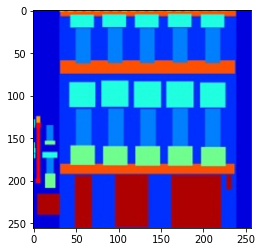

In [5]:
#check_dataset
plt.imshow(train_dataset[0][0].squeeze().permute(1,2,0) * EPS + MU)
plt.show()

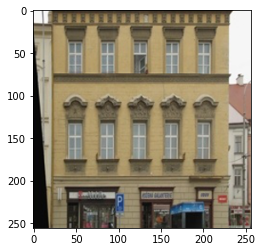

In [6]:
plt.imshow(train_dataset[0][1].squeeze().permute(1,2,0) * EPS + MU)
plt.show()

In [7]:
def init_conv_weight_normal(unit, mean=0., std=0.02):
    unit.weight.data.normal_(mean, std)
    unit.bias.data.zero_()

In [8]:
class DownConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel=4, stride=2, padding=1, batchnorm=True, dropout=None):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel, stride, stride)
        self.conv.apply(init_conv_weight_normal)
        self.batchnorm = batchnorm

In [9]:
class ConvBlock(nn.Module):
    activation_funcs = {
        'Leaky': nn.LeakyReLU(0.2),
        'Relu': nn.ReLU()
    }
    conv_types = {
        'Conv': nn.Conv2d,
        'DeConv': nn.ConvTranspose2d
    }
    
    def __init__(self, in_channels, out_channels, kernel=3, stride=1, padding=1, batchnorm=True, dropout=None, func='Leaky', conv_type='Conv'):
        super().__init__()
        self.batchnorm = batchnorm
        self.dropout = dropout
        self.conv = self.conv_types[conv_type]
        if dropout is not None:
            self.dropout = nn.Dropout2d(dropout)
        
        self.conv_1 = self.conv(in_channels, out_channels, kernel_size=kernel, stride=stride, padding=padding)
        self.conv_1.apply(init_conv_weight_normal)
        self.act_func = self.activation_funcs[func]
        
        # self.batchnorm_module = nn.BatchNorm2d(out_channels)
        self.batchnorm_module = nn.InstanceNorm2d(out_channels)
        # self.batchnorm_module.apply(init_conv_weight_normal)
        
    def forward(self, x):
        y = self.conv_1(x)
        y = self.batchnorm_module(y) if self.batchnorm else y
        y = self.act_func(y)
        y = self.dropout(y) if self.dropout is not None else y
        
        return y

In [10]:
class ImgGenerator(nn.Module):
    def __init__(self, in_chanels, out_chanels, dropout_rate=0.5):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.encoder = nn.ModuleList([
            ConvBlock(in_chanels, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256, ),
            ConvBlock(256, 256, ),
            ConvBlock(256, 512, ),
            ConvBlock(512, 512, ),
            ConvBlock(512, 512, batchnorm=False)
        ])
        
        self.decoder = nn.ModuleList([
            ConvBlock(512 + 512, 512, func='Relu', conv_type='DeConv',),
            ConvBlock(512 + 512, 512, func='Relu', conv_type='DeConv'),
            ConvBlock(256 + 512, 256, func='Relu', conv_type='DeConv', dropout=self.dropout_rate),
            ConvBlock(256 + 256, 256, func='Relu', conv_type='DeConv'),
            ConvBlock(256 + 128, 128, func='Relu', conv_type='DeConv', dropout=self.dropout_rate),
            ConvBlock(128 + 64, 64, func='Relu', conv_type='DeConv'),
            ConvBlock(64, out_chanels, func='Relu', conv_type='DeConv', batchnorm=False, kernel=3),
        ])
        
    def forward(self, x):
        
        enc_list = list()
#         enc = self.encoder[0](enc)
#         enc_list.append(enc)
        enc = x
        for i in range(len(self.encoder)):
            enc = self.encoder[i](enc)
            enc_list.append(enc)
            
#         enc = torch.cat([enc, enc[-2]], axis=1)
#         dec = self.decoder[0](enc)
        dec = enc_list[-1]
        for i in range(len(self.decoder) - 1):
            # print(dec.shape)
            enc_idx = len(self.decoder) - i - 2
            dec = torch.cat([dec, enc_list[enc_idx]], axis=1)
            dec = self.decoder[i](dec)
            
        dec = self.decoder[-1](dec)
        # print(dec.shape)
        
        return self.tanh(dec)

In [11]:
class Discriminator(nn.Module):

    def __init__(self, in_channels=6):
        super().__init__()
        self.model = nn.Sequential(
            ConvBlock(in_channels, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 256),
            ConvBlock(256, 512),
            nn.Conv2d(512, 1, kernel_size=4),
            # nn.AdaptiveAvgPool2d((1, 1), ),
        )
        

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        y = self.model(x)
        return y

In [12]:
def display_progress(template, fake, original, figsize=(10,5)):
    with torch.no_grad():
        template = template.cpu().permute(1, 2, 0) * EPS + MU
        fake = fake.cpu().permute(1, 2, 0) * EPS + MU
        original = original.cpu().permute(1, 2, 0) * EPS + MU

    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ax[0].imshow(template)
    ax[1].imshow(original)
    ax[2].imshow(fake)
    plt.show()

Модель Pix2Pix - обучает генератор и дискриминатор

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
class Pix2Pix:

    def __init__(self, device, in_channels=3, out_channels=3, g_lr=22e-5, d_lr=2e-4):

        self.G = ImgGenerator(in_channels, out_channels)
        self.D = Discriminator(in_channels + out_channels)
        
        self.device = device
        self.G.to(self.device)
        self.D.to(self.device)

        self.discriminator_criterion = nn.BCEWithLogitsLoss()
        self.generator_criterion = nn.L1Loss()

        self.g_optimizer = torch.optim.Adam(self.G.parameters(), lr=g_lr, betas=(0.5, 0.999))
        self.d_optimizer = torch.optim.Adam(self.D.parameters(), lr=d_lr, betas=(0.5, 0.999))

                    
    def train_epoch(self, dataloader):
        loss_g_l, loss_d_l = list(), list()
        for batch in dataloader:
            template, original= batch
            template = template.to(self.device)
            original = original.to(self.device)

            self.G.eval()
            self.D.train()


            # with torch.no_grad():
            fake = self.G(template)
            
            
            # update Discriminator
            self.d_optimizer.zero_grad() 
            # print(fake.shape, template.shape)
            
            fake_logits = self.D(template, fake.detach())
            orig_logits = self.D(template, original)
            fake_loss = self.discriminator_criterion(fake_logits, torch.zeros_like(fake_logits))
            real_loss = self.discriminator_criterion(orig_logits, torch.ones_like(orig_logits))
            loss_d = (real_loss + fake_loss) / 2
            
            loss_d.backward()
            self.d_optimizer.step()
            
            loss_d_l.append(loss_d.detach().cpu().item())
            
            # update G
            self.g_optimizer.zero_grad()
            self.G.train()
            self.D.eval()

            # fake = self.G(template)
            
            logits = self.D(template, fake)
            
            loss_d = self.discriminator_criterion(logits, torch.ones_like(logits))
            loss_g = self.generator_criterion(fake, original)
            loss_g = loss_d + 100 * loss_g
    
            loss_g.backward()
            self.g_optimizer.step()  
            
            loss_g_l.append(loss_g.detach().cpu().item())
            
            
        
        mean_loss_g = np.mean(loss_g_l)
        mean_loss_d = np.mean(loss_d_l)
        return mean_loss_g, mean_loss_d
            

In [15]:
import gc
# del model
torch.cuda.empty_cache()
gc.collect()

4702

In [16]:
model = Pix2Pix(device)

In [17]:
!nvidia-smi

Tue Dec 28 23:21:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    47W / 250W |   1101MiB / 16280MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

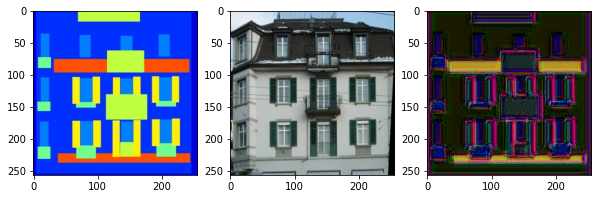

In [18]:
with torch.no_grad():
  model.G.eval()
  template, original = val_dataset[random.randrange(len(val_dataset))]
  fake = model.G(template.unsqueeze(0).to(model.device))
  display_progress(template, fake[0], original)

  0%|          | 0/39 [00:00<?, ?it/s]

1 20.702911229133605 0.45873085733503105


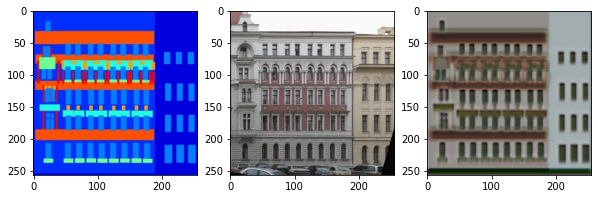

  3%|▎         | 1/39 [04:40<2:57:24, 280.11s/it]

2 21.203791704177856 0.4140961142256856


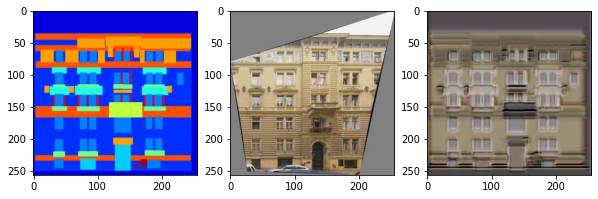

  5%|▌         | 2/39 [09:20<2:52:44, 280.12s/it]

3 21.181356329917907 0.42375240962952376


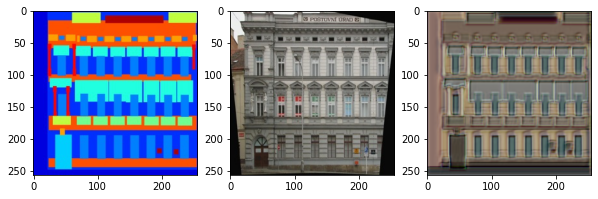

  8%|▊         | 3/39 [14:00<2:48:04, 280.11s/it]

4 21.275319209098814 0.39215565551072357


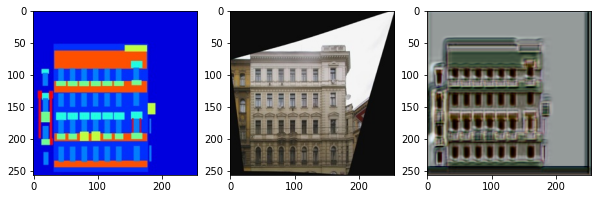

 10%|█         | 4/39 [18:40<2:43:25, 280.16s/it]

5 21.244597911834717 0.4122354092635214


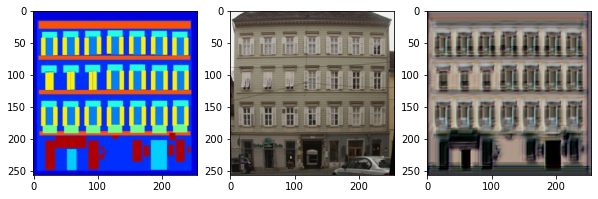

 13%|█▎        | 5/39 [23:20<2:38:47, 280.21s/it]

6 20.94403932571411 0.41296441171318293


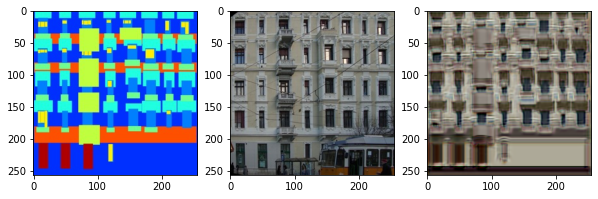

 15%|█▌        | 6/39 [28:01<2:34:09, 280.29s/it]

7 20.92873998641968 0.4084598742797971


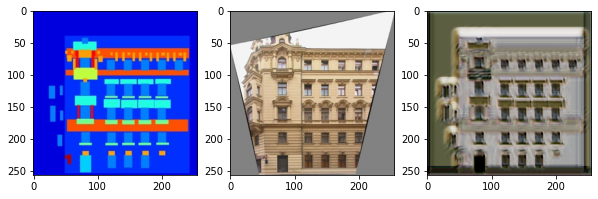

 18%|█▊        | 7/39 [32:42<2:29:33, 280.43s/it]

8 20.80393906593323 0.403048699144274


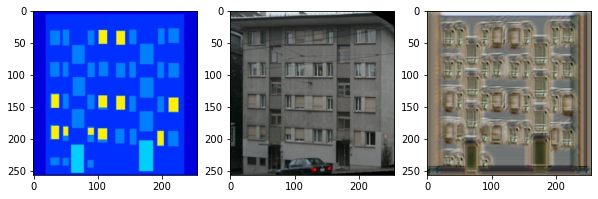

 21%|██        | 8/39 [37:22<2:24:56, 280.54s/it]

9 20.819930529594423 0.40939375445246695


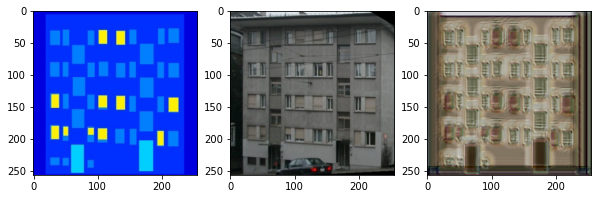

 23%|██▎       | 9/39 [42:03<2:20:18, 280.62s/it]

10 20.80214928150177 0.39375122368335724


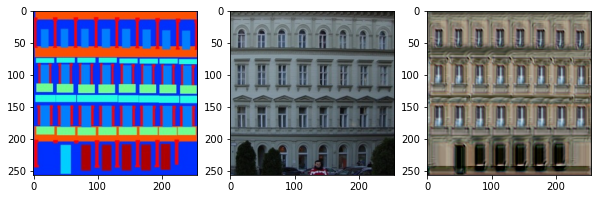

 26%|██▌       | 10/39 [46:44<2:15:38, 280.65s/it]

11 20.786209678649904 0.41560281174257396


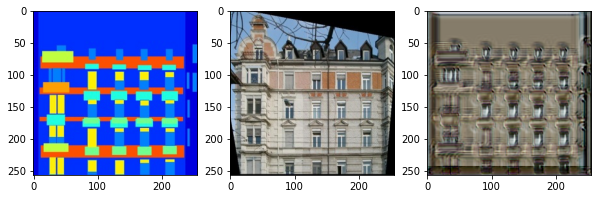

 28%|██▊       | 11/39 [51:25<2:11:00, 280.72s/it]

12 20.63708939552307 0.41377194348722696


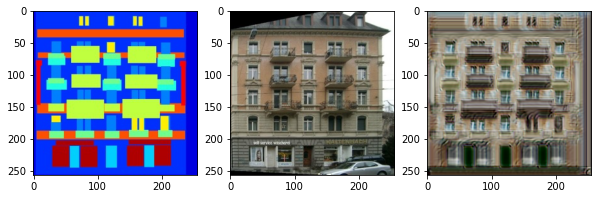

 31%|███       | 12/39 [56:06<2:06:20, 280.78s/it]

13 20.573196477890015 0.4029328928142786


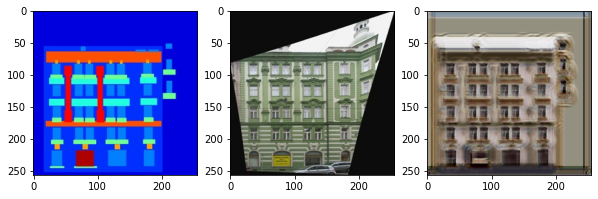

 33%|███▎      | 13/39 [1:00:47<2:01:41, 280.84s/it]

14 20.62215162277222 0.41384359005838633


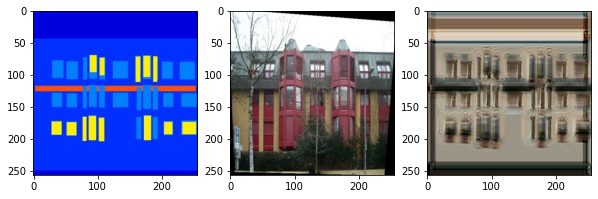

 36%|███▌      | 14/39 [1:05:28<1:57:01, 280.88s/it]

15 20.49180892944336 0.4020165533572435


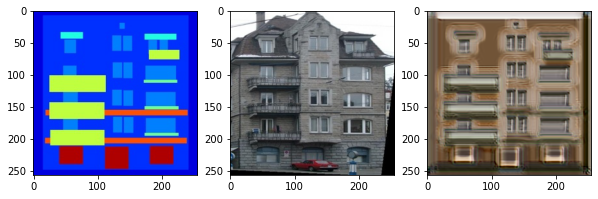

 38%|███▊      | 15/39 [1:10:09<1:52:21, 280.90s/it]

16 20.48055103302002 0.4195102312415838


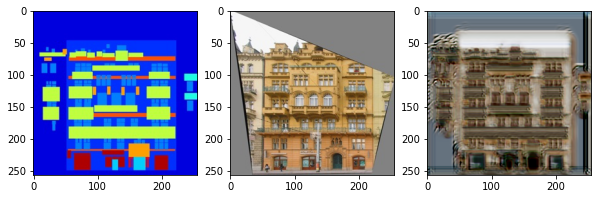

 41%|████      | 16/39 [1:14:50<1:47:41, 280.94s/it]

17 20.51353970527649 0.4255236661806703


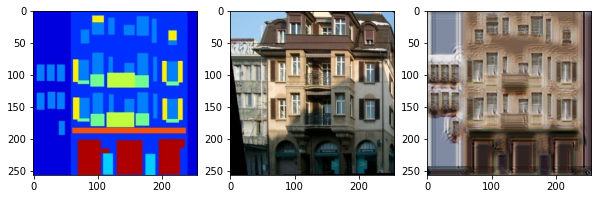

 44%|████▎     | 17/39 [1:19:31<1:43:02, 281.03s/it]

18 20.47789948940277 0.40101818725466726


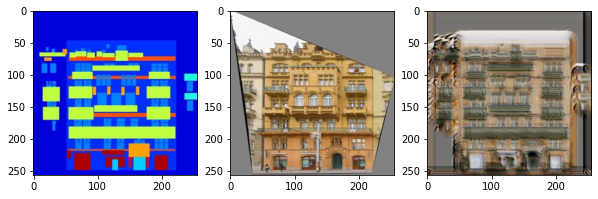

 46%|████▌     | 18/39 [1:24:12<1:38:23, 281.10s/it]

19 20.43818344593048 0.4085072996094823


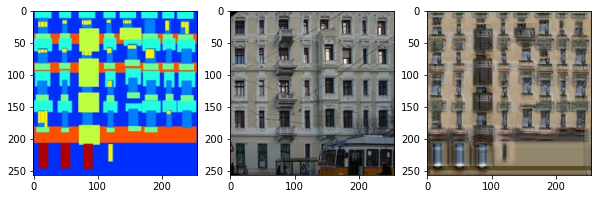

 49%|████▊     | 19/39 [1:28:53<1:33:41, 281.10s/it]

20 20.485494170188904 0.4177867004647851


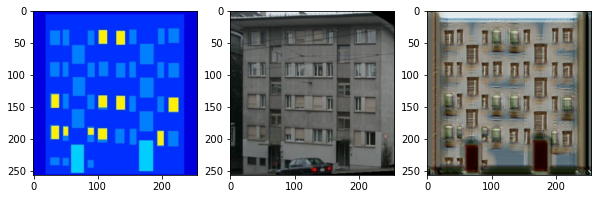

 51%|█████▏    | 20/39 [1:33:34<1:29:00, 281.07s/it]

21 20.400079526901244 0.40476112999022007


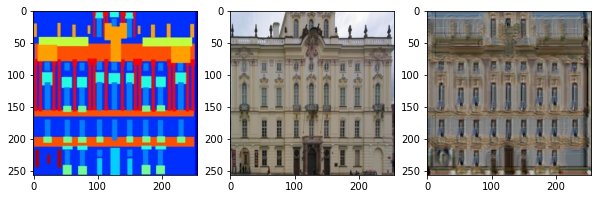

 54%|█████▍    | 21/39 [1:38:15<1:24:18, 281.05s/it]

22 20.344175353050233 0.4096104407683015


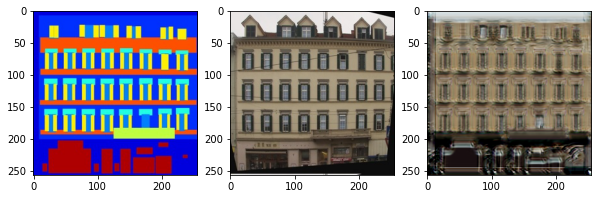

 56%|█████▋    | 22/39 [1:42:56<1:19:38, 281.08s/it]

23 20.125970978736877 0.4355263908207416


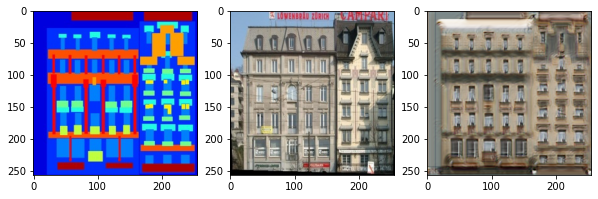

 59%|█████▉    | 23/39 [1:47:37<1:14:57, 281.10s/it]

24 20.22844123363495 0.4241747421771288


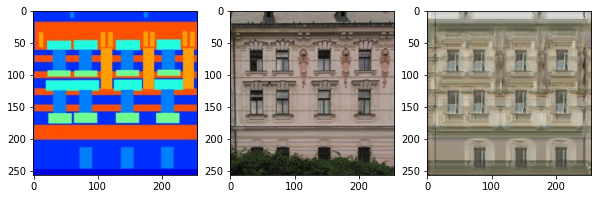

 62%|██████▏   | 24/39 [1:52:19<1:10:16, 281.11s/it]

25 20.371909422874452 0.42501192636787893


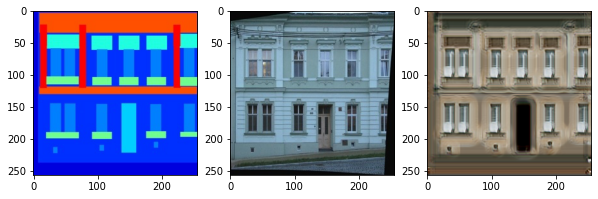

 64%|██████▍   | 25/39 [1:57:00<1:05:35, 281.13s/it]

26 20.43349657058716 0.42167414773255585


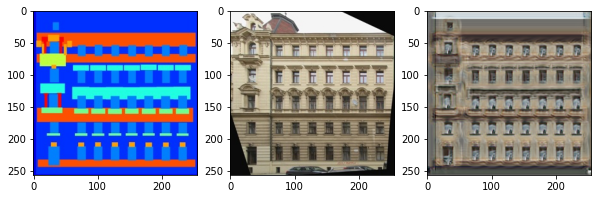

 67%|██████▋   | 26/39 [2:01:41<1:00:55, 281.18s/it]

27 20.170784168243408 0.41968881331384184


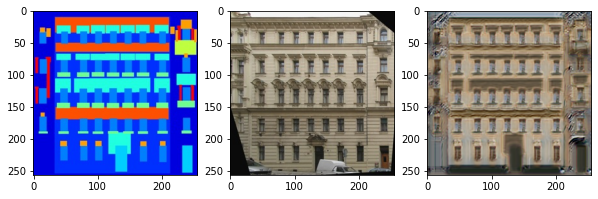

 69%|██████▉   | 27/39 [2:06:22<56:14, 281.24s/it]  

28 20.005354824066163 0.42527584474533797


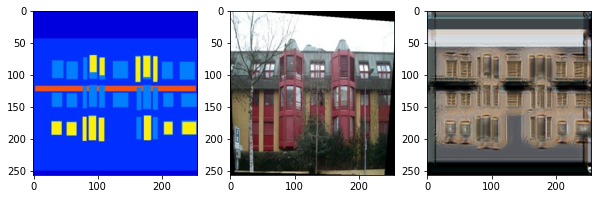

 72%|███████▏  | 28/39 [2:11:04<51:34, 281.28s/it]

29 20.104194145202637 0.41682390112429857


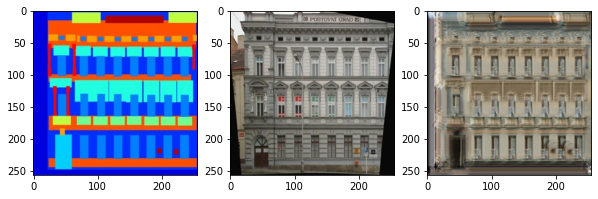

 74%|███████▍  | 29/39 [2:15:45<46:52, 281.27s/it]

30 20.031141300201416 0.41159285496920345


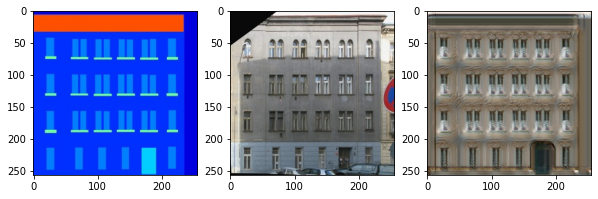

 77%|███████▋  | 30/39 [2:20:26<42:11, 281.29s/it]

31 20.150293765068053 0.4153428699076176


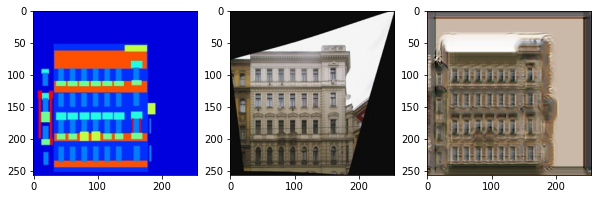

 79%|███████▉  | 31/39 [2:25:08<37:30, 281.32s/it]

32 20.069172921180726 0.43341642405837777


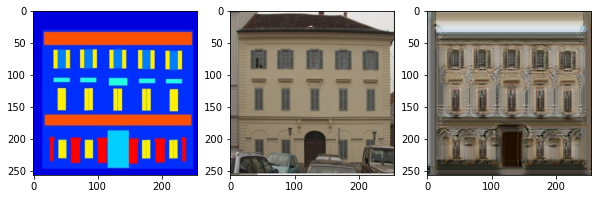

 82%|████████▏ | 32/39 [2:29:49<32:49, 281.36s/it]

33 19.915083537101747 0.42873776141554115


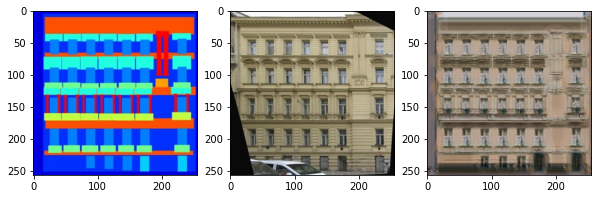

 85%|████████▍ | 33/39 [2:34:31<28:08, 281.45s/it]

34 19.891960821151734 0.41576923739165067


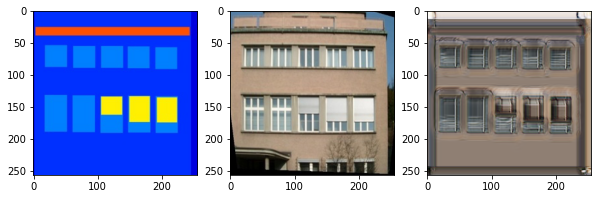

 87%|████████▋ | 34/39 [2:39:12<23:27, 281.47s/it]

35 19.991519804000855 0.421176168192178


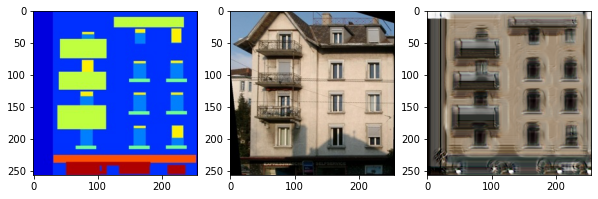

 90%|████████▉ | 35/39 [2:43:54<18:46, 281.50s/it]

36 19.931375608444213 0.42339817628264426


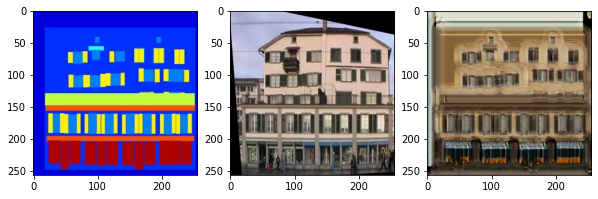

 92%|█████████▏| 36/39 [2:48:35<14:04, 281.51s/it]

37 19.845156779289244 0.4188139993324876


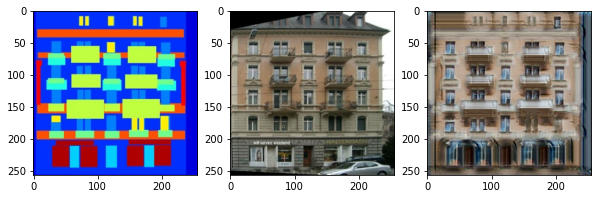

 95%|█████████▍| 37/39 [2:53:17<09:23, 281.53s/it]

38 19.853796820640564 0.43226864613592625


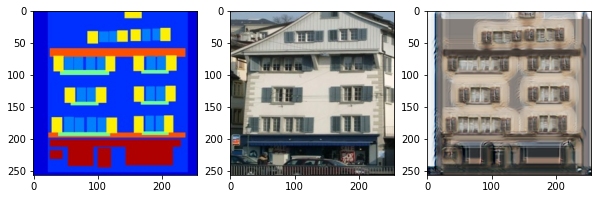

 97%|█████████▋| 38/39 [2:57:59<04:41, 281.53s/it]

39 19.944510021209716 0.3997454757243395


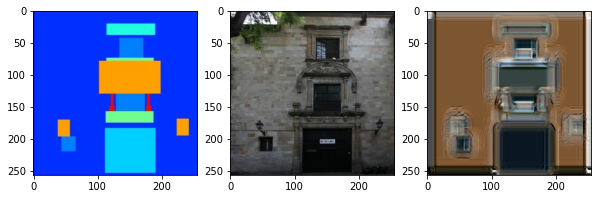

100%|██████████| 39/39 [3:02:40<00:00, 281.03s/it]

CPU times: user 3h 1min 56s, sys: 33.9 s, total: 3h 2min 30s
Wall time: 3h 2min 40s


In [19]:
%%time
for i_epoch in tqdm.tqdm(range(1, 40)):
    loss_g, loss_d = model.train_epoch(train_dataloader)
    print(i_epoch, loss_g, loss_d)

    with torch.no_grad():
        model.G.eval()
        template, original = val_dataset[random.randrange(len(val_dataset))]
        fake = model.G(template.unsqueeze(0).to(model.device))
        display_progress(template, fake[0], original)
        del fake
        gc.collect()
        torch.cuda.empty_cache()